In [1]:
import numpy as np

#Define network

순전파와 역전파가 어떻게 구현되는지 확인해보세요!

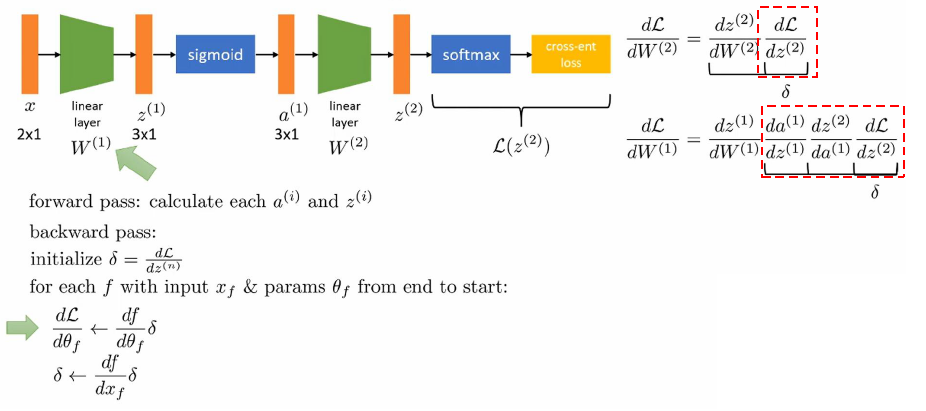

In [2]:
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # forward
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [3]:
class MultiLayerNet:
    
    def __init__(self, input_size, hidden_size_list, output_size):
        self.params = {}
        self.layers = OrderedDict()
        self.lastLayer = SoftmaxWithLoss()

        layer_sizes = [input_size] + hidden_size_list + [output_size]

        for i in range(1, len(layer_sizes)):
            fan_in = layer_sizes[i-1]
            self.params[f'W{i}'] = np.random.randn(fan_in, layer_sizes[i]) * np.sqrt(2.0 / fan_in)
            self.params[f'b{i}'] = np.zeros(layer_sizes[i])

        for i in range(1, len(layer_sizes) - 1):
            self.layers[f'Affine{i}'] = Affine(self.params[f'W{i}'], self.params[f'b{i}'])
            self.layers[f'Relu{i}'] = Relu()

        last_i = len(layer_sizes) - 1
        self.layers[f'Affine{last_i}'] = Affine(self.params[f'W{last_i}'], self.params[f'b{last_i}'])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)

        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        affine_count = 0
        for name, layer in self.layers.items():
            if "Affine" in name:
                affine_count += 1
                grads[f'W{affine_count}'] = layer.dW
                grads[f'b{affine_count}'] = layer.db

        return grads


#Layers

각 레이어에는 init, forward, backward 함수가 정의되어 있습니다.

In [4]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)

        # 계산 그래프를 직접 그려보세요(권장)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [6]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

#Functions

복습차원에서 빈칸을 채워봅시다!

In [7]:
def softmax(x):
    '''
    x: n x num_class
    '''
    # 계산 안정성 추가
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [8]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

#Optimizers

파라미터와 기울기를 인수로 받아서 파라미터를 갱신합니다.

SGD는 파라미터를 업데이트할 때, 각 반복마다 계산된 **기울기(gradient)**를 이용하여 파라미터를 업데이트합니다.

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta J(\theta_t)
$$

- $\theta_t$ : 파라미터  
- $\eta$ : 학습률(learning rate)  
- $\nabla_\theta J(\theta_t)$ : 파라미터에 대한 손실 함수의 기울기(gradient)  

In [9]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

Momentum은 이전 기울기를 반영하여 학습을 가속화하는 방법입니다.

$$
v_{t+1} = \alpha v_t - \eta \nabla_\theta J(\theta_t)
$$
$$
\theta_{t+1} = \theta_t + v_{t+1}
$$

- $ v_t $ : 이전 기울기 업데이트
- $ \alpha $ : 모멘텀 하이퍼파라미터 (0 < $ \alpha $ < 1)
- $ \nabla_\theta J(\theta_t) $ : 현재 기울기
- $ \eta $ : 학습률

In [10]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

Adagrad는 학습이 진행될수록 각 파라미터의 학습률이 감소합니다.

$$
G_t = G_{t-1} + \nabla_\theta J(\theta_t)^2
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \nabla_\theta J(\theta_t)
$$

- $ G_t $ : 기울기의 제곱 합(누적)
- $ \epsilon $ : 작은 값 (수치 안정성 보장)
- $ \eta $ : 학습률
- $ \nabla_\theta J(\theta_t) $ : 현재 기울기

In [11]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] ** 2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#Training

**MNIST 손글씨 dataset**

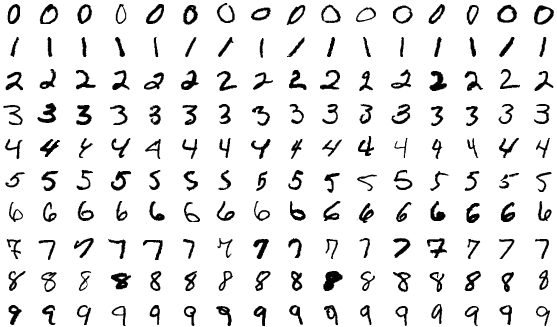

In [12]:
from torchvision import datasets

# MNIST load
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True)


# flatten(28*28), normalization(0~1)
x_train = mnist_train.data.view(-1, 28 * 28).numpy().astype('float32') / 255.0
t_train = mnist_train.targets.numpy()
x_test  = mnist_test.data.view(-1, 28 * 28).numpy().astype('float32') / 255.0
t_test  = mnist_test.targets.numpy()

# one-hot encoding
n = len(np.unique(t_train))  # 보통 10
t_train = np.eye(n)[t_train]
t_test  = np.eye(n)[t_test]

print(f'x_train.shape: {x_train.shape}')  # (60000, 784)
print(f't_train.shape: {t_train.shape}')  # (60000, 10)
print(f'x_test.shape:  {x_test.shape}')   # (10000, 784)
print(f't_test.shape:  {t_test.shape}')   # (10000, 10)

x_train.shape: (60000, 784)
t_train.shape: (60000, 10)
x_test.shape:  (10000, 784)
t_test.shape:  (10000, 10)


https://docs.pytorch.org/vision/stable/datasets.html

MNIST말고도 다양한 데이터셋이 있습니다 :)



1. batch_size, learning_rate 등 하이퍼파라미터를 변경해보세요!
2. 세 종류의 optimizer를 써보고 train loss 그래프를 비교해보세요!

In [13]:
network = TwoLayerNet(input_size=28*28*1, hidden_size=50, output_size=10)
network = MultiLayerNet(input_size=28*28*1, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

# 데이터셋 60000개, 배치 당 100개 -> 600번 반복해야 한 데이터셋 다 봄(=1epoch)
iters_num = 6000 # 몇 epoch 일까요?
train_size = x_train.shape[0] # 60000
batch_size = 100
lr_dict = {'sgd': 0.02, 'momentum': 0.01, 'adagrad': 0.01}

optimizers = {'sgd':SGD, 'momentum':Momentum, 'adagrad':AdaGrad}
train_loss_list = {key:[] for key in optimizers.keys()}

iter_per_epoch = max(train_size / batch_size, 1)


for key in optimizers.keys():
    print(f"\n====== Training with {key.upper()} optimizer ======")
    # Re-initialize network for each optimizer to ensure a fair comparison
    current_network = MultiLayerNet(input_size=28*28*1, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

    if key == 'momentum':
        current_optimizer = optimizers[key](lr=lr_dict[key], momentum=0.9)
    else:
        current_optimizer = optimizers[key](lr=lr_dict[key])

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad = current_network.gradient(x_batch, t_batch)
        current_optimizer.update(current_network.params, grad)

        loss = current_network.loss(x_batch, t_batch)
        train_loss_list[key].append(loss)

        if i % iter_per_epoch == 0:
            train_acc = current_network.accuracy(x_train, t_train)
            test_acc = current_network.accuracy(x_test, t_test)
            print('Epoch {:.0f}, train: {:.4f}, test: {:.4f}'.format(i//iter_per_epoch, train_acc, test_acc))


====== Training with SGD optimizer ======
Epoch 0, train: 0.1128, test: 0.1077
Epoch 1, train: 0.9267, test: 0.9279
Epoch 2, train: 0.9485, test: 0.9448
Epoch 3, train: 0.9596, test: 0.9547
Epoch 4, train: 0.9584, test: 0.9515
Epoch 5, train: 0.9709, test: 0.9615
Epoch 6, train: 0.9738, test: 0.9648
Epoch 7, train: 0.9730, test: 0.9622
Epoch 8, train: 0.9810, test: 0.9685
Epoch 9, train: 0.9700, test: 0.9597

====== Training with MOMENTUM optimizer ======
Epoch 0, train: 0.0987, test: 0.0956
Epoch 1, train: 0.9465, test: 0.9446
Epoch 2, train: 0.9633, test: 0.9563
Epoch 3, train: 0.9761, test: 0.9677
Epoch 4, train: 0.9806, test: 0.9669
Epoch 5, train: 0.9843, test: 0.9695
Epoch 6, train: 0.9861, test: 0.9706
Epoch 7, train: 0.9884, test: 0.9767
Epoch 8, train: 0.9818, test: 0.9686
Epoch 9, train: 0.9899, test: 0.9752

====== Training with ADAGRAD optimizer ======
Epoch 0, train: 0.0990, test: 0.0960
Epoch 1, train: 0.9635, test: 0.9585
Epoch 2, train: 0.9752, test: 0.9639
Epoch 3, tr

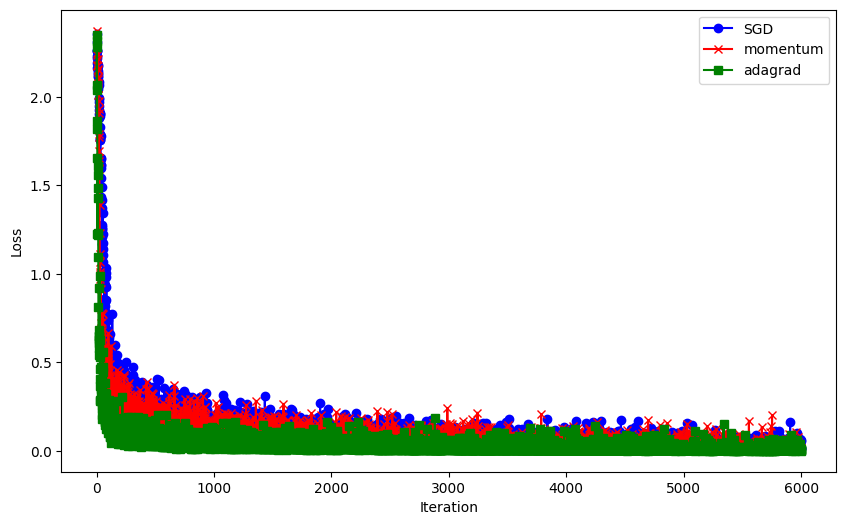

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_loss_list['sgd'], label='SGD', marker='o', linestyle='-', color='b')
plt.plot(train_loss_list['momentum'], label='momentum', marker='x', linestyle='-', color='r')
plt.plot(train_loss_list['adagrad'], label='adagrad', marker='s', linestyle='-', color='g')


plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.legend()

plt.show()

### 문제: 각 optimizer의 특징을 비교해주세요!
- SGD: SGD는 미니배치에서 계산한 기울기를 이용해 손실이 줄어드는 방향으로 파라미터를 조금씩 갱신하는 가장 기본적인 최적화 방법입니다. 구현이 간단하고 계산 비용이 낮다는 장점이 있지만, 방향에 따라 기울기 크기가 크게 다른 지형에서는 최적점으로 곧장 가지 못하고 지그재그로 흔들리며 이동해 수렴이 느려질 수 있습니다. 또한 학습률 선택에 민감해서 값이 너무 크면 학습이 불안정해지고, 너무 작으면 학습이 매우 느려질 수 있습니다.
- momentum: Momentum은 이전에 이동했던 방향과 그 관성을 현재 업데이트에 반영하는 방법입니다. 한 번 유리한 방향이 잡히면 그 방향으로 더 빠르게 진행하고, 반대로 좌우로 흔들리기 쉬운 방향의 진동은 줄여주는 효과가 있습니다. 그 결과 SGD보다 더 빠르고 안정적으로 수렴하는 경우가 많고, 평평한 구간에서도 관성 덕분에 학습이 정체되지 않고 계속 진행되는 경향이 있습니다.
- adagrad: AdaGrad는 각 파라미터가 얼마나 자주, 얼마나 크게 변해왔는지를 누적해서 파라미터별로 학습률을 자동으로 조절하는 방법입니다. 많이 변했던 파라미터는 더 보수적으로 업데이트하고, 덜 변했던 파라미터는 상대적으로 크게 업데이트하도록 조정되어 초반 학습이 안정적이고 빠른 편인 경우가 많습니다. 다만 누적값이 계속 쌓이면서 학습이 진행될수록 업데이트 크기가 지나치게 작아질 수 있어, 오래 학습하면 변화가 거의 멈추는 한계가 있습니다.